<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Basics-of-camera" data-toc-modified-id="Basics-of-camera-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Basics of camera</a></span><ul class="toc-item"><li><span><a href="#Camera-coordinates" data-toc-modified-id="Camera-coordinates-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Camera coordinates</a></span></li><li><span><a href="#Projection-Matrices" data-toc-modified-id="Projection-Matrices-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Projection Matrices</a></span></li></ul></li><li><span><a href="#Dataset" data-toc-modified-id="Dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dataset</a></span><ul class="toc-item"><li><span><a href="#Visualizing-the-pointcloud" data-toc-modified-id="Visualizing-the-pointcloud-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Visualizing the pointcloud</a></span></li><li><span><a href="#Dataset-handler" data-toc-modified-id="Dataset-handler-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Dataset handler</a></span><ul class="toc-item"><li><span><a href="#Generators" data-toc-modified-id="Generators-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Generators</a></span></li></ul></li></ul></li><li><span><a href="#Disparity" data-toc-modified-id="Disparity-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Disparity</a></span><ul class="toc-item"><li><span><a href="#Depth-from-disparity" data-toc-modified-id="Depth-from-disparity-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Depth from disparity</a></span></li><li><span><a href="#Disparity-map" data-toc-modified-id="Disparity-map-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Disparity map</a></span></li><li><span><a href="#Depth-map" data-toc-modified-id="Depth-map-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Depth map</a></span></li></ul></li></ul></div>

In [5]:
import cv2
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# Basics of camera

## Camera coordinates

Right hand rule system
- x direction goes to the right (u for image shown in gray)
- y direction goes down (v for image)
- z direction goes outside from the camera

In this image the ($X_{c}$, $Y_{c}$ and $Z_{c}$) is the coordinate for a point in the environment (world coordinate system) which is observed by the camera coordinate system. This point is captured in the image (shown in gray) by the camera as a point (x,y).

<img src="images/image_coordinate.png" width=800 height=800 />

In [6]:
poses = pd.read_csv('dataset/poses/00.txt', delimiter=' ', header=None)
print('Shape of position dataframe:', poses.shape)
poses.head()
print('First position:')
first_pose = np.array(poses.iloc[0]).reshape((3,4)).round(2)
print(first_pose)

Shape of position dataframe: (4541, 12)
First position:
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1. -0.]]


<IPython.core.display.Javascript object>


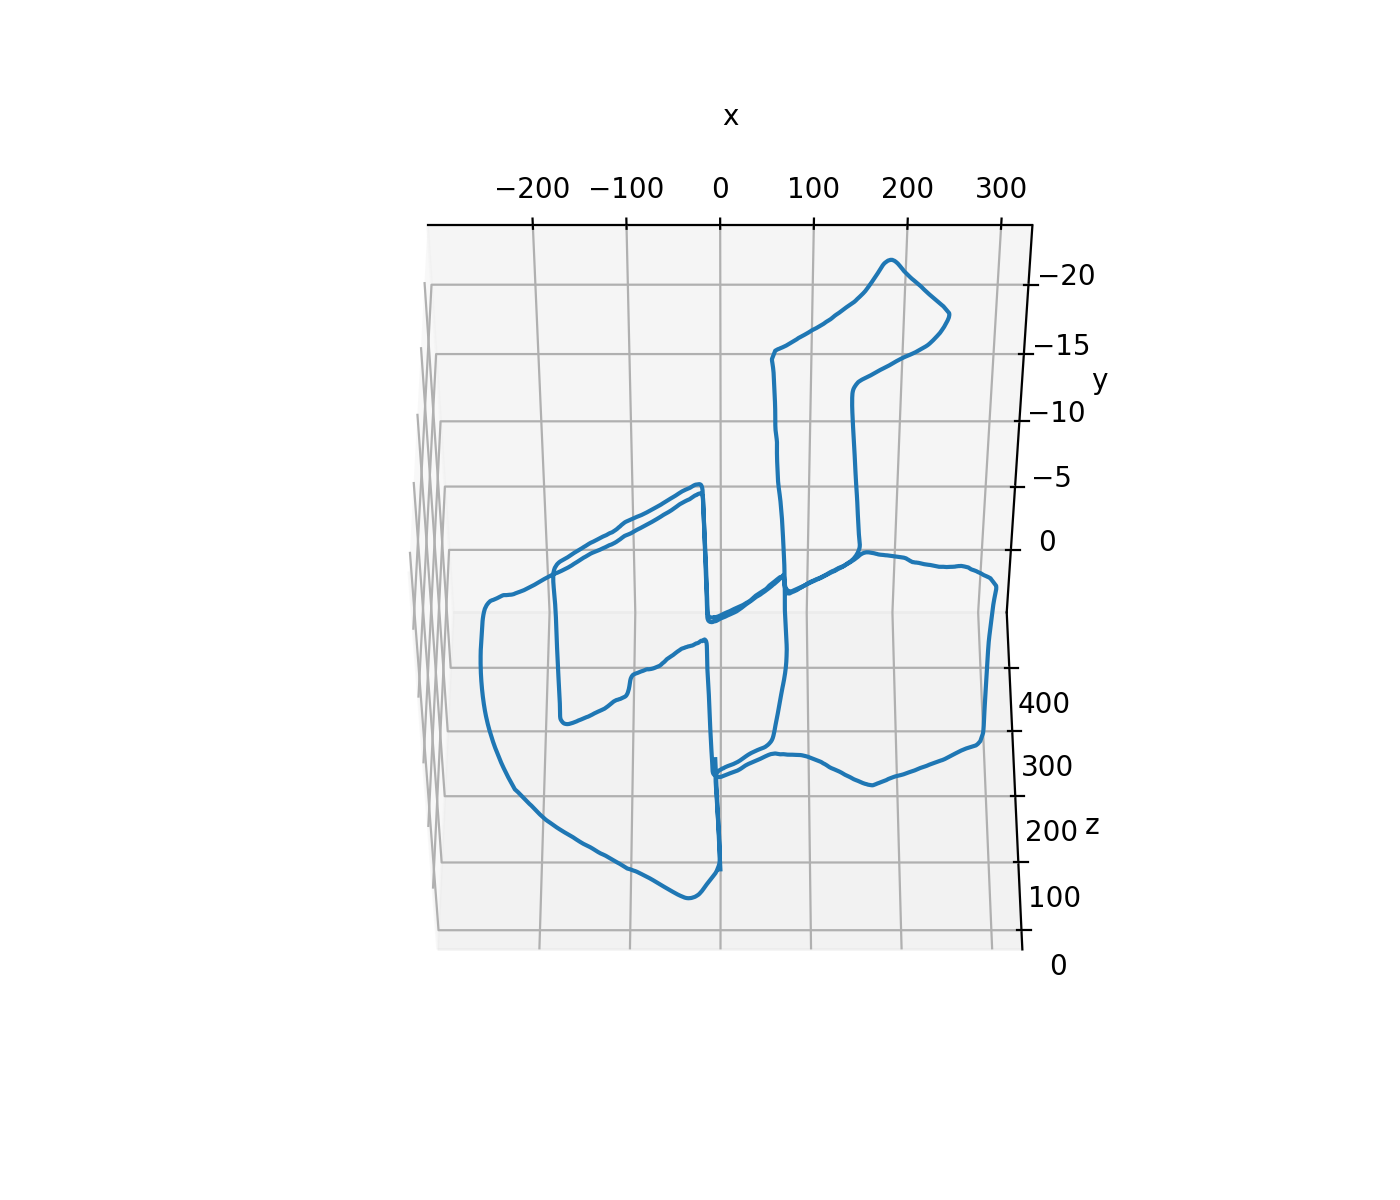

In [7]:
gt = np.zeros((len(poses), 3, 4))
for i in range(len(poses)):
    gt[i] = np.array(poses.iloc[i]).reshape((3, 4))
    
%matplotlib notebook
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(gt[:, :, 3][:, 0], gt[:, :, 3][:, 1], gt[:, :, 3][:, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(elev=-40, azim=270)

## Projection Matrices

These matrices contain intrinsic information about the camera's focal length and optical center. Further, they also contain tranformation information which relates each camera's coordinate frame to the global coordinate frame. A projection matrix (3*4) takes 3D coordinates in the global coordinate frame and projects them onto the image plane of the camera through the formula present below.

<img src="images/projection_matrices1.png" width=800 height=800 />

NOTE: here $\tau$ is basically the depth of the object from the camera, so we lose the depth information and project everything in the 2d plane.

<img src="images/projection_matrices2.png" width=800 height=800 />

NOTE: intrinsic matrix $$ K = \begin{bmatrix} f_{x} & 0 & c_{x} \\ 0 & f_{y} & c_{y} \\ 0 & 0 & 1 \end{bmatrix}$$ where f are the focal point and c is the optical center of the image.

<img src="images/projection_matrices3.png" width=800 height=800 />

In [8]:
# We can load in our sensor calibration data as follows
calib = pd.read_csv('dataset/sequences/00/calib.txt', delimiter=' ', header=None, index_col=0)
calib

,1,2,3,4,5,6,7,8,9,10,11,12
0,,,,,,,,,,,,
P0:,718.856000,0.000000,607.192800,0.000000,0.000000,718.856000,185.215700,0.000000,0.000000,0.000000,1.000000,0.000000
P1:,718.856000,0.000000,607.192800,-386.144800,0.000000,718.856000,185.215700,0.000000,0.000000,0.000000,1.000000,0.000000
P2:,718.856000,0.000000,607.192800,45.382250,0.000000,718.856000,185.215700,-0.113089,0.000000,0.000000,1.000000,0.003780
P3:,718.856000,0.000000,607.192800,-337.287700,0.000000,718.856000,185.215700,2.369057,0.000000,0.000000,1.000000,0.004915
Tr:,0.000428,-0.999967,-0.008084,-0.011985,-0.007211,0.008081,-0.999941,-0.054040,0.999974,0.000486,-0.007207,-0.292197


In [9]:
# Decomposing a projection matrix with OpenCV
# P = Intrinsic (R|T)
P1 = np.array(calib.loc['P1:']).reshape((3,4))
k1, r1, t1, _, _, _, _ = cv2.decomposeProjectionMatrix(P1)
t1 = t1 / t1[3]
print('Intrinsic Matrix:')
print(k1)
print('Rotation Matrix:')
print(r1)
print('Translation Vector:')
print(t1.round(4))

Intrinsic Matrix:
[[718.856    0.     607.1928]
 [  0.     718.856  185.2157]
 [  0.       0.       1.    ]]
Rotation Matrix:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Translation Vector:
[[ 0.5372]
 [ 0.    ]
 [-0.    ]
 [ 1.    ]]


# Dataset

In [25]:
import cv2
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime

NOTE: use generator to process a sequence of images

In [26]:
file_path = "dataset/sequences/00/image_0/"
left_images = os.listdir(file_path)
print(" the number of images in this sequence is:", len(left_images))

 the number of images in this sequence is: 4541


<IPython.core.display.Javascript object>


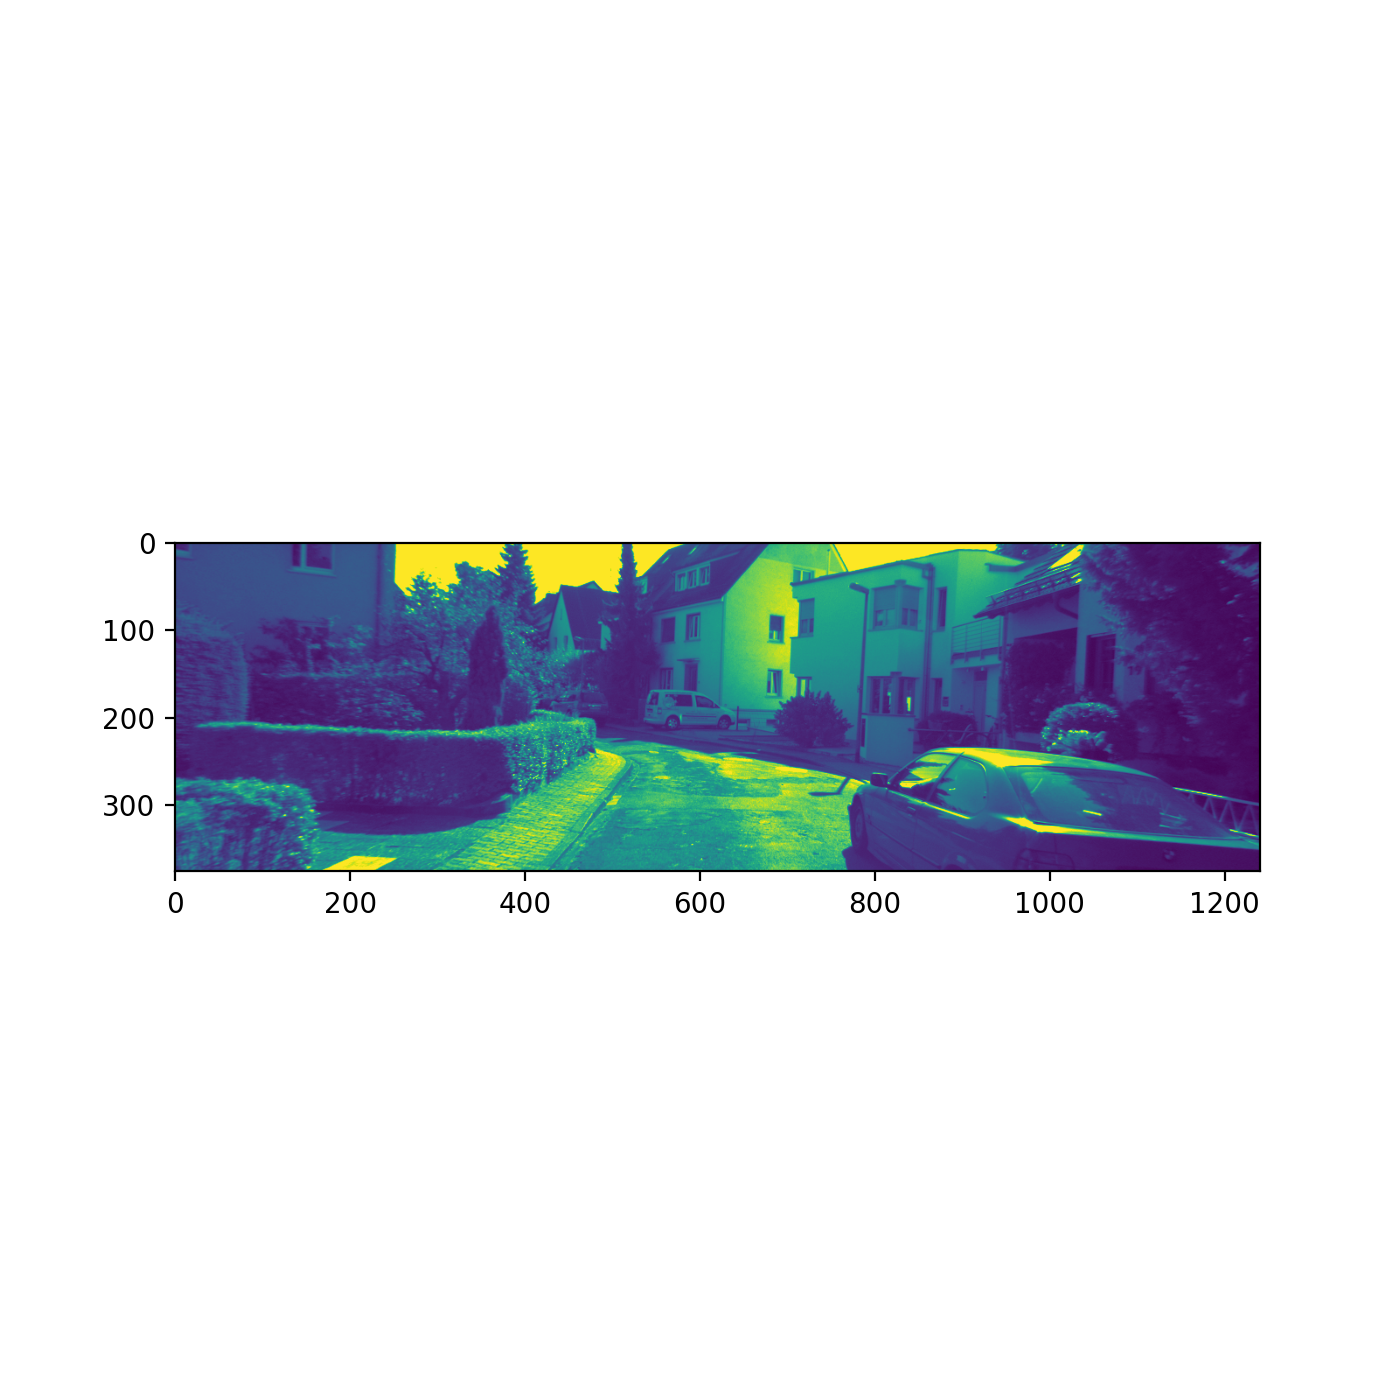

(376, 1241)

In [57]:
plt.figure(figsize=(7,7))
first_image = cv2.imread(file_path + left_images[0], 0)
plt.imshow(first_image)
first_image.shape

## Visualizing the pointcloud

In [16]:
file_path = "dataset/sequences/00/"
velodyne_file_path = os.listdir(file_path + "velodyne")
pointclouds = np.fromfile(file_path + "velodyne/" + velodyne_file_path[0], dtype=np.float32)
# reshaping it to x,y,z and one more value
pointclouds = pointclouds.reshape(-1,4)
pointclouds.shape

(112328, 4)

<IPython.core.display.Javascript object>


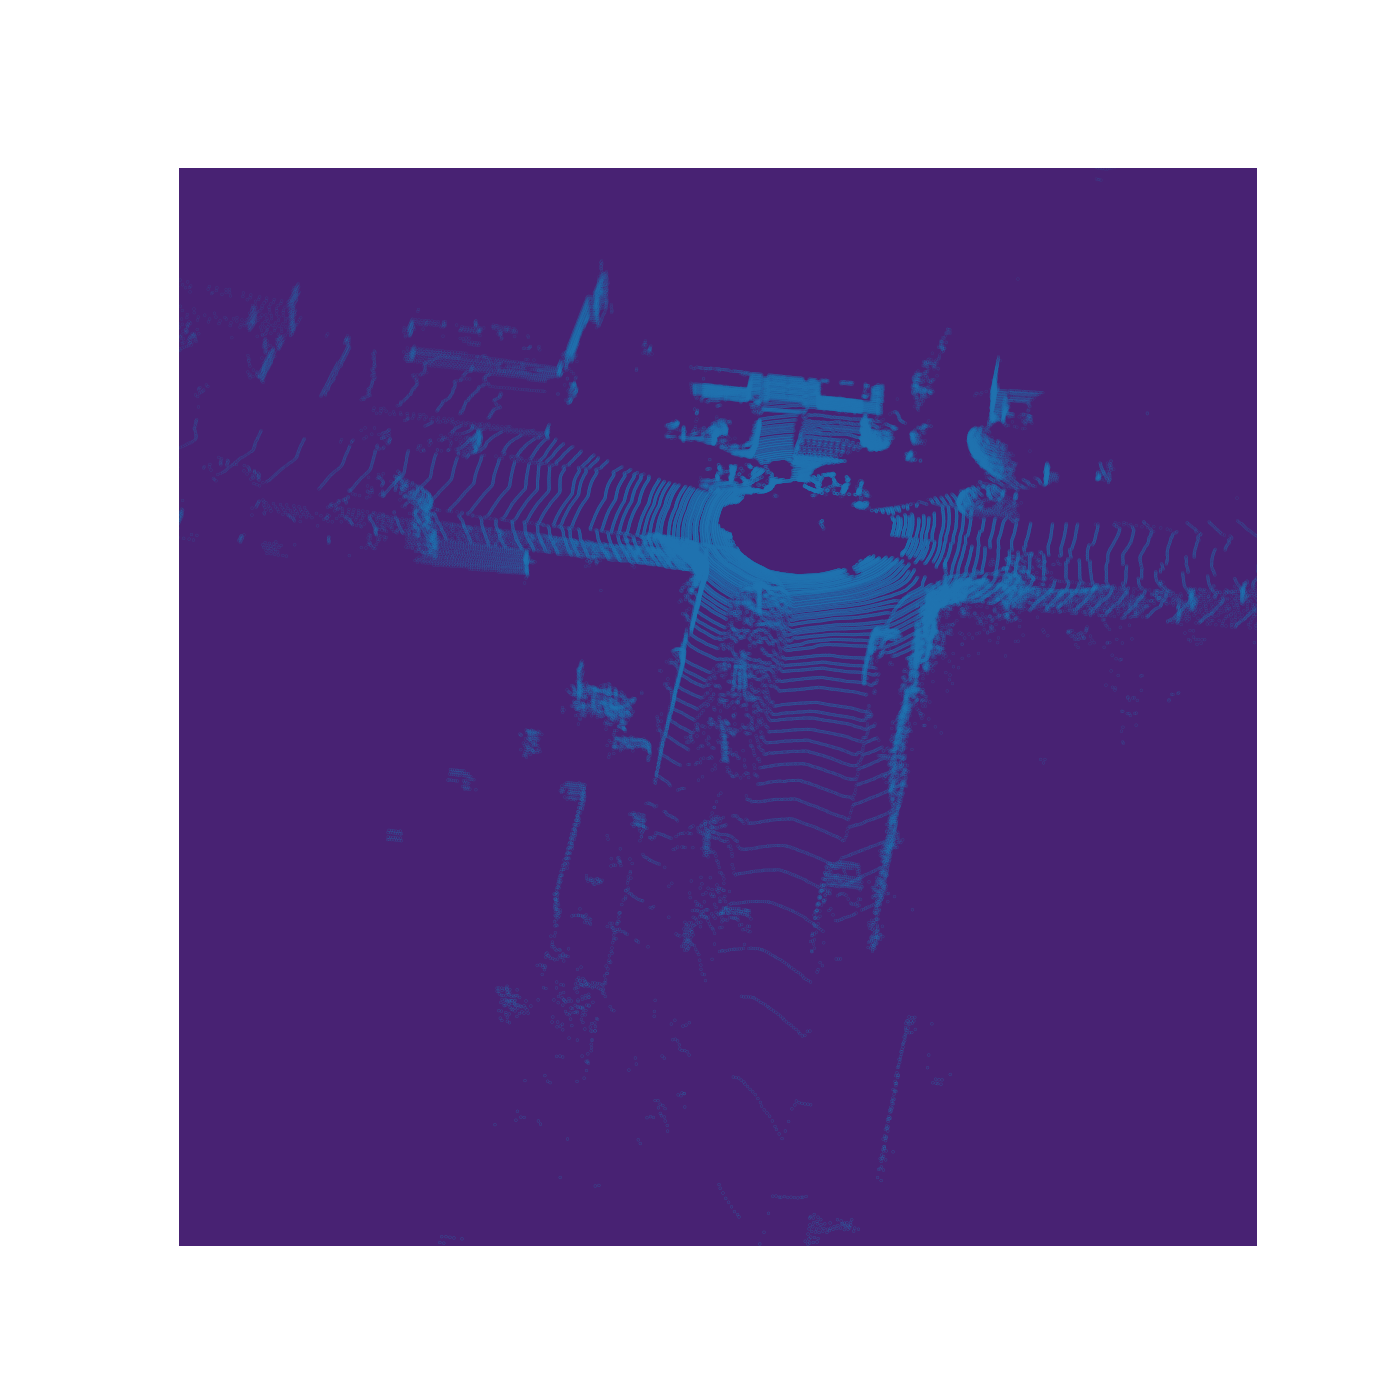

In [23]:
%matplotlib notebook
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111,projection="3d")
x = pointclouds[:,0]
y = pointclouds[:,1]
z = pointclouds[:,2]
ax.set_box_aspect((np.ptp(x),np.ptp(y),np.ptp(z)))
ax.scatter(x,y,z,s=0.01)
ax.grid(False)
ax.axis("off")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.view_init(elev=40, azim=100)

## Dataset handler

### Generators

Because the dataset is so bit and will require a lot of ram to load in the memory and store it, it s better to use generators which loads only one element of a sequence at a time. To use a generator use the list comprehension but instead of [ ] use ( ) and the next operator will have the next element and will not save the previous elements.

In [18]:
generators = (i for i in range(1,6))
next(generators)

1

In [30]:
class Dataset_Handler():
    def __init__(self, sequence, lidar=True):
        import pandas as pd
        import os
        import cv2
        
        #if handler contains lidar info
        self.lidar = lidar
        
        #file paths and ground truth poses
        self.seq_dir = 'dataset/sequences/{}/'.format(sequence)
        self.poses_dir = 'dataset/poses/{}.txt'.format(sequence)
        poses = pd.read_csv(self.poses_dir, delimiter=' ', header=None)
        
        #names of files to iterate through
        self.left_image_files = os.listdir(self.seq_dir + 'image_0')
        self.right_image_files = os.listdir(self.seq_dir + 'image_1')
        self.velodyne_files = os.listdir(self.seq_dir + 'velodyne')
        self.num_frames = len(self.left_image_files)
        self.lidar_path = self.seq_dir + 'velodyne/'
        
        #calibration details for scene, P0 and P1 are Grayscale cams, P2 and P3 are RGB cams
        calib = pd.read_csv(self.seq_dir + 'calib.txt', delimiter=' ', header=None, index_col=0)
        self.P0 = np.array(calib.loc['P0:']).reshape((3,4))
        self.P1 = np.array(calib.loc['P1:']).reshape((3,4))
        self.P2 = np.array(calib.loc['P2:']).reshape((3,4))
        self.P3 = np.array(calib.loc['P3:']).reshape((3,4))
        # This is the transformation matrix for LIDAR
        self.Tr = np.array(calib.loc['Tr:']).reshape((3,4))
        
        #times and ground truth poses
        self.times = np.array(pd.read_csv(self.seq_dir + 'times.txt', delimiter=' ', header=None))
        self.gt = np.zeros((len(poses), 3, 4))
        for i in range(len(poses)):
            self.gt[i] = np.array(poses.iloc[i]).reshape((3, 4))
        
        #use generators
        self.reset_frames()
        
        #just for testing, store original frame to memory
        self.first_image_left = cv2.imread(self.seq_dir + 'image_0/' 
                                           + self.left_image_files[0], 0)
        self.first_image_right = cv2.imread(self.seq_dir + 'image_1/' 
                                           + self.right_image_files[0], 0)
        self.second_image_left = cv2.imread(self.seq_dir + 'image_0/' 
                                           + self.left_image_files[1], 0)
        if self.lidar:
            self.first_pointcloud = np.fromfile(self.lidar_path + self.velodyne_files[0],
                                                dtype=np.float32, 
                                                count=-1).reshape((-1, 4))
        self.imheight = self.first_image_left.shape[0]
        self.imwidth = self.first_image_left.shape[1]
            
            
    def reset_frames(self):
        # Resets all generators to the first frame of the sequence
        self.images_left = (cv2.imread(self.seq_dir + 'image_0/' + name_left, 0)
                            for name_left in self.left_image_files)
        self.images_right = (cv2.imread(self.seq_dir + 'image_1/' + name_right, 0)
                            for name_right in self.right_image_files)
        if self.lidar:
            self.pointclouds = (np.fromfile(self.lidar_path + velodyne_file, 
                                            dtype=np.float32, 
                                            count=-1).reshape((-1, 4))
                                for velodyne_file in self.velodyne_files)
        pass

In [61]:
#loading the 00th sequence from the dataset
handler = Dataset_Handler('00')
print(handler.imheight)
plt.imshow(next(handler.images_left));

376


# Disparity

The disparity is the apparent motion of objects between a pair of stereo images. To experience this, try closing one eye and then rapidly open it while closing the other one. You will note that closer objects will move significantly while objects further away will move very little.

Given a pair of stereo images, to compute the disparity map, we first match every pixel in the left image with its corresponding pixel in the right image. Then we compute the distance for each pair of matching pixels. Finally, the disparity map is obtained by representing such distance values as an intensity image.

<img src="images/disparity.png" width=900 height=800 />

## Depth from disparity

<img src="images/stereo_camera.png" width=500 height=500 />

using triangulation method, we get,

$$
  Z = \frac{f b}{d}
$$

$$
  d = x_L - x_R
$$

where, d is the disparity and $x_L$ and $x_R$ are difference in horizontal pixel location of the point projected onto the left and right image planes and b is the baseline.





## Disparity map

openCV has 2 methods to calculate the disparity map:
1. bm
2. sgbm

sgbm performs better than bm but is comparitively slower

In [71]:
def compute_left_disparity_map(img_left, img_right, matcher='bm'):
    
    sad_window = 6
    num_disparities = sad_window*16
    block_size = 11
    matcher_name = matcher
    
    if matcher_name == 'bm':
        matcher = cv2.StereoBM_create(numDisparities=num_disparities,
                                      blockSize=block_size
                                     )
        
    elif matcher_name == 'sgbm':
        matcher = cv2.StereoSGBM_create(numDisparities=num_disparities,
                                        minDisparity=0,
                                        blockSize=block_size,
                                        P1 = 8 * 3 * sad_window ** 2,
                                        P2 = 32 * 3 * sad_window ** 2,
                                        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
                                       )

    disparity = matcher.compute(img_left, img_right).astype(np.float32)/16
    
    return disparity

<IPython.core.display.Javascript object>


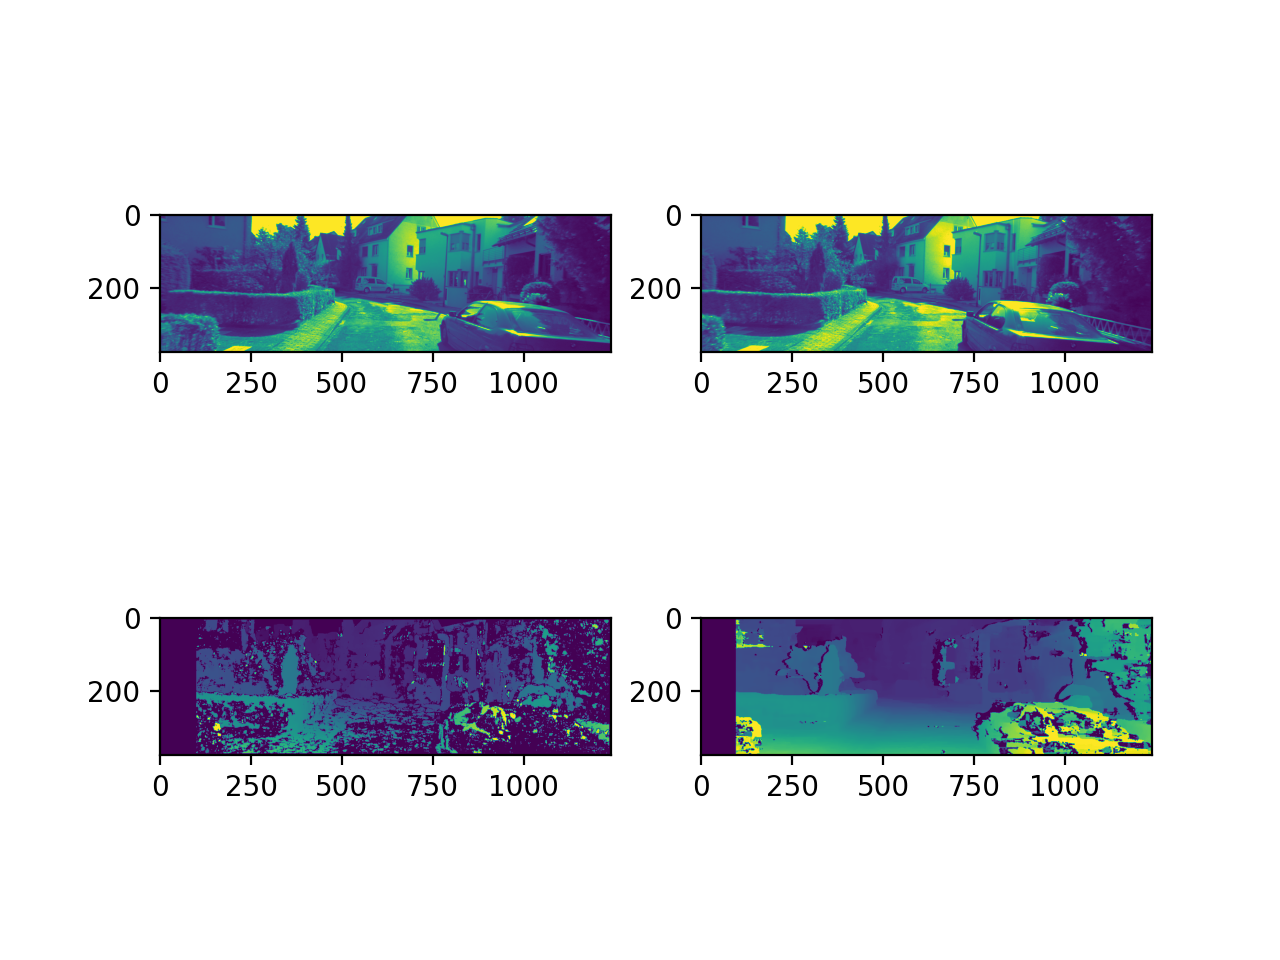

In [72]:
disparity_bm = compute_left_disparity_map(handler.first_image_left, 
                                  handler.first_image_right, 
                                  matcher='bm')
disparity_sgbm = compute_left_disparity_map(handler.first_image_left, 
                                  handler.first_image_right, 
                                  matcher='sgbm')
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax1.imshow(handler.first_image_left)
ax2.imshow(handler.first_image_right)
ax3.imshow(disparity_bm)
ax4.imshow(disparity_sgbm);

## Depth map

$$Z = \frac{f b}{d}$$

we will be using the above formula to calculate the depth image, here f is the f_x from the intrinsic matric, b is the baseline and d is the disparity map we get earlier

In [101]:
# to get parameters from the projection matrix
def decompose_projection_matrix(p):

    k, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(p)
    t = (t / t[3])[:3]
    
    return k, r, t

In [102]:
def calc_depth_map(disparity_map, k_left, t_left, t_right, rectified=True):
    
    # Get focal length of x axis for left camera
    f = k_left[0][0]
    
    # Calculate baseline of stereo pair
    if rectified:
        b = t_right[0] - t_left[0] 
    else:
        b = t_left[0] - t_right[0]
        
    # Avoid instability and division by zero
    disparity_map[disparity_map == 0.0] = 0.1
    disparity_map[disparity_map == -1.0] = 0.1
    
    # Make empty depth map then fill with depth
    depth_map = np.ones(disparity_map.shape)
    depth_map = f * b / disparity_map
    
    return depth_map

In [106]:
def stereo_2_depth(img_left, img_right, P0, P1, matcher='bm', rectified=True):
    
    # Compute disparity map
    disp = compute_left_disparity_map(img_left, 
                                      img_right, 
                                      matcher=matcher)
    # Decompose projection matrices
    k_left, r_left, t_left = decompose_projection_matrix(P0)
    k_right, r_right, t_right = decompose_projection_matrix(P1)
    # Calculate depth map for left camera
    depth = calc_depth_map(disp, k_left, t_left, t_right)
    
    return depth

In [112]:
depth_map = stereo_2_depth(handler.first_image_left,
                      handler.first_image_right,
                      handler.P0,
                      handler.P1,
                      matcher="sgbm",
                      rectified="True")

<IPython.core.display.Javascript object>


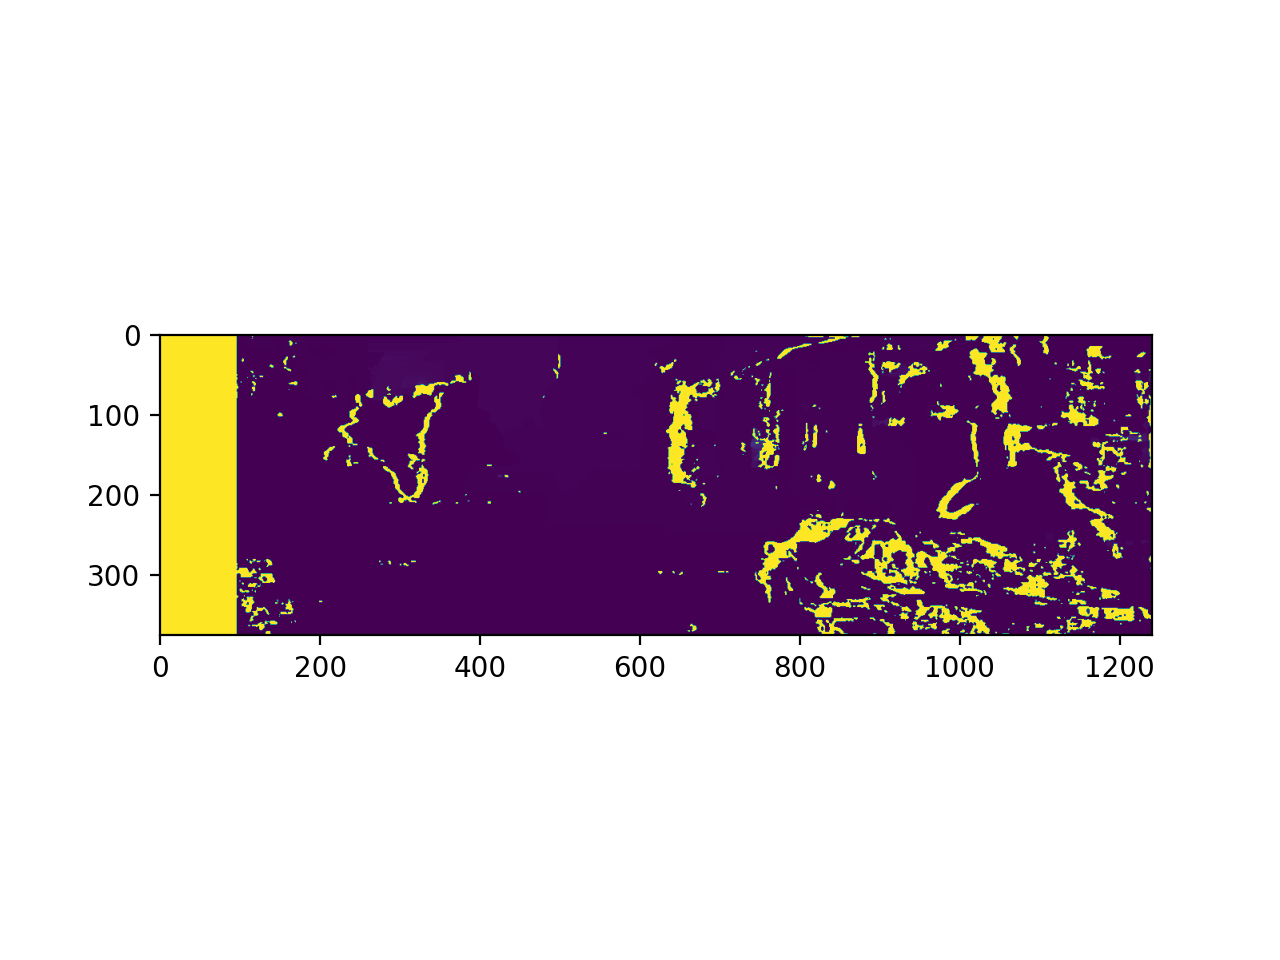

In [115]:
fig = plt.figure()
plt.imshow(depth_map);

In [116]:
print(depth.max())
depth[depth < 3000].max()

3861.447942459941


686.4796444444443

NOTE: here, the pixel value 3861 corresponds to the disparity value 0 and -1, which means this depth value is not useful to us. Hence, a filter can be applied to remove this value from processing.